# Dielectric Properties of Materials: A Materials Design Analysis # 

# Introduction

Dielectric materials are crucial to modern electronics, ranging applications from energy storage capacitiors to tunable mirowave devices. However, designing and discovering optimal dielectric materials is a challenge due to complex relation among atomic struncture, chemistry and electronic behavior. But, with the power of informatics we can decypher this complex relationship towards designing efficient dielectric materials tailored to various applications. 

This notebook presents a roadmap as to how we can leverage the power of data in accelearating the novel dielectric materials discovery by combining:

**Computational datasets**: 1,056 materials with DFT-calculated dielectric properties (Petousis et al., Sci. Data 2017), including electronic (e_electronic) and ionic (e_total) contributions.

**Machine learning**: Unsupervised clustering (k-means) and feature analysis to identify hidden structure-property relationships.

**Domain knowledge**: Crystal symmetry (space_group), bond lengths (avg_bond), and band gap (band_gap) as key descriptors.


**Key Questions:**

- How do features (e.g., bond lengths, band_gap, space_group, volume, structure) correlate with dielectric constants?

- Can we identify subgroups (e.g., ferroelectrics) with exceptional properties?

- What design rules emerge for high-κ or low-loss materials?

**Why This Matters:**

**For Researchers**: Identifies candidate materials for high-performance dielectrics.

**For Industry**: Accelerates the design of capacitors, insulators, and optoelectronic devices.

**For Methodology**: Demonstrates how informatics bridges DFT calculations and experimental discovery.

**Workflow**

This project analyzes a dataset of materials properties to identify potential ferroelectric materials with high dielectric constants.

 1. Data Loading and Preprocessing:
   - Loaded the 'dielectric_constant' dataset using matminer.
   - Explored the data's structure using .info() and .describe() and removed outliers based on quantile analysis.

 2. Exploratory Data Analysis (EDA):
   - Visualized the distribution of key features (nsites, volume, band gap, etc.) using boxplots and histograms.
   - Analyzed the relationship between features and the target variable ('pot_ferroelectric').

 3. Feature Engineering:
   - Created a new 'combined_feature' by combining several features ('poly_electronic', 'poly_total', and 'n').
   - Performed feature scaling using MinMaxScaler.
   - Trained a RandomForestRegressor model to determine feature importance.
   - Identified the most influential features for predicting 'pot_ferroelectric'.

 4. Model Selection and Evaluation:
   - Applied GridSearchCV to optimize hyperparameters for Logistic Regression, Decision Tree, and KNN classifiers.
   - Compared model performance based on accuracy and classification reports.

 5. Clustering Analysis:
   - Added bond length features to the dataset.
   - Performed K-Means clustering based on multiple features and observed cluster characteristics.
   - Visualized clusters based on different properties like bond length, band gap, etc.
   - Provided cluster statistics showing average values of important features for each cluster.

 6. Material Identification and Design Rules:
   - Identified potential high-κ candidates based on cluster assignments, poly_total, and band gap.
   - Presented design rules and potential applications based on identified clusters.
   - Created a combined table including cluster statistics, design rules and applications.

**About Dataset**

The dielectric_constant dataset includes 1,056 inorganic materials with dielectric properties computed using DFPT-PBE. It supports materials discovery in dielectrics and optics. Each entry contains:

**material_id**: Unique Materials Project ID

**formula**: Chemical formula of the material

**band_gap**: Band gap (indicator of material conductivity)

**n**: Refractive index

**e_electronic**: Electronic contribution to the dielectric tensor

**e_total**: Total dielectric tensor (electronic + ionic)

**poly_electronic**: Average eigenvalue of e_electronic

**poly_total**: Average eigenvalue of e_total

**nsites**: Number of atoms in the unit cell

**volume**: Volume of the unit cell (Å³)

**space_group**: Crystallographic space group (integer)

**pot_ferroelectric**: Indicates potential ferroelectricity

**structure**: Material structure as a pandas Series

**cif, poscar, meta**: Optional structure/metadata fields

**Reference**: Petousis et al., Scientific Data, 2017

**Data Source**: Figshare

**File Type**: JSON (gzipped)

SHA256: 8eb24812148732786cd7c657eccfc6b5ee66533429c2cfbcc4f0059c0295e8b6

In [1]:
# lets install important dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

In [3]:
def warn(*args, **kwargs):
    pass

import warnings 
warnings.warn = warn

# 1. Data Loading and Preprocessing

In [4]:
!pip install matminer
! pip install pymatgen
from pymatgen.core import Structure
from matminer.datasets import get_available_datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.0/809.0 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 29.9 MB/s eta 0:00:00
  Created wheel for bibtexparser: filename=bibtexparser-1.4.3-py3-none-any.whl size=43550 

In [5]:
%env MATMINER_DATA data
from matminer.datasets import load_dataset
df = load_dataset("dielectric_constant")
df.head()

env: MATMINER_DATA=data
Making dataset storage folder at data
Fetching dielectric_constant.json.gz from https://ndownloader.figshare.com/files/13213475 to data/dielectric_constant.json.gz


Fetching https://ndownloader.figshare.com/files/13213475 in MB: 0.8867839999999999MB [00:00, 231.27MB/s]      


,material_id,formula,nsites,space_group,volume,structure,band_gap,e_electronic,e_total,n,poly_electronic,poly_total,pot_ferroelectric,cif,meta,poscar
0,mp-441,Rb2Te,3,225,159.501208,"[[1.75725875 1.2425695 3.04366125] Rb, [5.271...",1.88,"[[3.44115795, -3.097e-05, -6.276e-05], [-2.837...","[[6.23414745, -0.00035252, -9.796e-05], [-0.00...",1.86,3.44,6.23,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Rb2 Te1\n1.0\n5.271776 0.000000 3.043661\n1.75...
1,mp-22881,CdCl2,3,166,84.298097,"[[0. 0. 0.] Cd, [ 4.27210959 2.64061969 13.13...",3.52,"[[3.34688382, -0.04498543, -0.22379197], [-0.0...","[[7.97018673, -0.29423886, -1.463590159999999]...",1.78,3.16,6.73,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Cd1 Cl2\n1.0\n3.850977 0.072671 5.494462\n1.78...
2,mp-28013,MnI2,3,164,108.335875,"[[0. 0. 0.] Mn, [-2.07904300e-06 2.40067320e+...",1.17,"[[5.5430849, -5.28e-06, -2.5030000000000003e-0...","[[13.80606079, 0.0006911900000000001, 9.655e-0...",2.23,4.97,10.64,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Mn1 I2\n1.0\n4.158086 0.000000 0.000000\n-2.07...
3,mp-567290,LaN,4,186,88.162562,[[-1.73309900e-06 2.38611186e+00 5.95256328e...,1.12,"[[7.09316738, 7.99e-06, -0.0003864700000000000...","[[16.79535386, 8.199999999999997e-07, -0.00948...",2.65,7.04,17.99,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,La2 N2\n1.0\n4.132865 0.000000 0.000000\n-2.06...
4,mp-560902,MnF2,6,136,82.826401,"[[1.677294 2.484476 2.484476] Mn, [0. 0. 0.] M...",2.87,"[[2.4239622, 7.452000000000001e-05, 6.06100000...","[[6.44055613, 0.0020446600000000002, 0.0013203...",1.53,2.35,7.12,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLDAUTYPE ...,Mn2 F4\n1.0\n3.354588 0.000000 0.000000\n0.000...


In [6]:
from matminer.datasets import get_all_dataset_info

print(get_all_dataset_info("dielectric_constant"))

Dataset: dielectric_constant
Description: 1,056 structures with dielectric properties, calculated with DFPT-PBE.
Columns:
	band_gap: Measure of the conductivity of a material
	cif: optional: Description string for structure
	e_electronic: electronic contribution to dielectric tensor
	e_total: Total dielectric tensor incorporating both electronic and ionic contributions
	formula: Chemical formula of the material
	material_id: Materials Project ID of the material
	meta: optional, metadata descriptor of the datapoint
	n: Refractive Index
	nsites: The \# of atoms in the unit cell of the calculation.
	poly_electronic: the average of the eigenvalues of the electronic contribution to the dielectric tensor
	poly_total: the average of the eigenvalues of the total (electronic and ionic) contributions to the dielectric tensor
	poscar: optional: Poscar metadata
	pot_ferroelectric: Whether the material is potentially ferroelectric
	space_group: Integer specifying the crystallographic structure of t

In [7]:
# lets get a bird eye view of our dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1056 entries, 0 to 1055
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   material_id        1056 non-null   object 
 1   formula            1056 non-null   object 
 2   nsites             1056 non-null   int64  
 3   space_group        1056 non-null   int64  
 4   volume             1056 non-null   float64
 5   structure          1056 non-null   object 
 6   band_gap           1056 non-null   float64
 7   e_electronic       1056 non-null   object 
 8   e_total            1056 non-null   object 
 9   n                  1056 non-null   float64
 10  poly_electronic    1056 non-null   float64
 11  poly_total         1056 non-null   float64
 12  pot_ferroelectric  1056 non-null   bool   
 13  cif                1056 non-null   object 
 14  meta               1056 non-null   object 
 15  poscar             1056 non-null   object 
dtypes: bool(1), float64(5), int64

In [8]:
df.describe()

,nsites,space_group,volume,band_gap,n,poly_electronic,poly_total
count,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000
mean,7.530303,142.970644,166.420376,2.119432,2.434886,7.248049,14.777898
std,3.388443,67.264591,97.425084,1.604924,1.148849,13.054947,19.435303
min,2.000000,1.000000,13.980548,0.110000,1.280000,1.630000,2.080000
25%,5.000000,82.000000,96.262337,0.890000,1.770000,3.130000,7.557500
50%,8.000000,163.000000,145.944691,1.730000,2.190000,4.790000,10.540000
75%,9.000000,194.000000,212.106405,2.885000,2.730000,7.440000,15.482500
max,20.000000,229.000000,597.341134,8.320000,16.030000,256.840000,277.780000


So, the dataset seems perfectly fine with no null values. All columns are complete, with data types spanning floats, integers, objects, and a boolean (pot_ferroelectric). The dataset also includes metadata (cif, poscar) for materials science applications. Lets explore the dataset more.

# 2. Exploratory Analysis

For further analysis data needs to be scaled and distributed properly, so we can fit the machine learning models and perform the other analysis effectively. We are going to use Box Plot to see if their are any potential outliers and fix them. Then, we will scale the data with MinMax scaling. We are just going to check the numerical columns only as per our analysis need. 

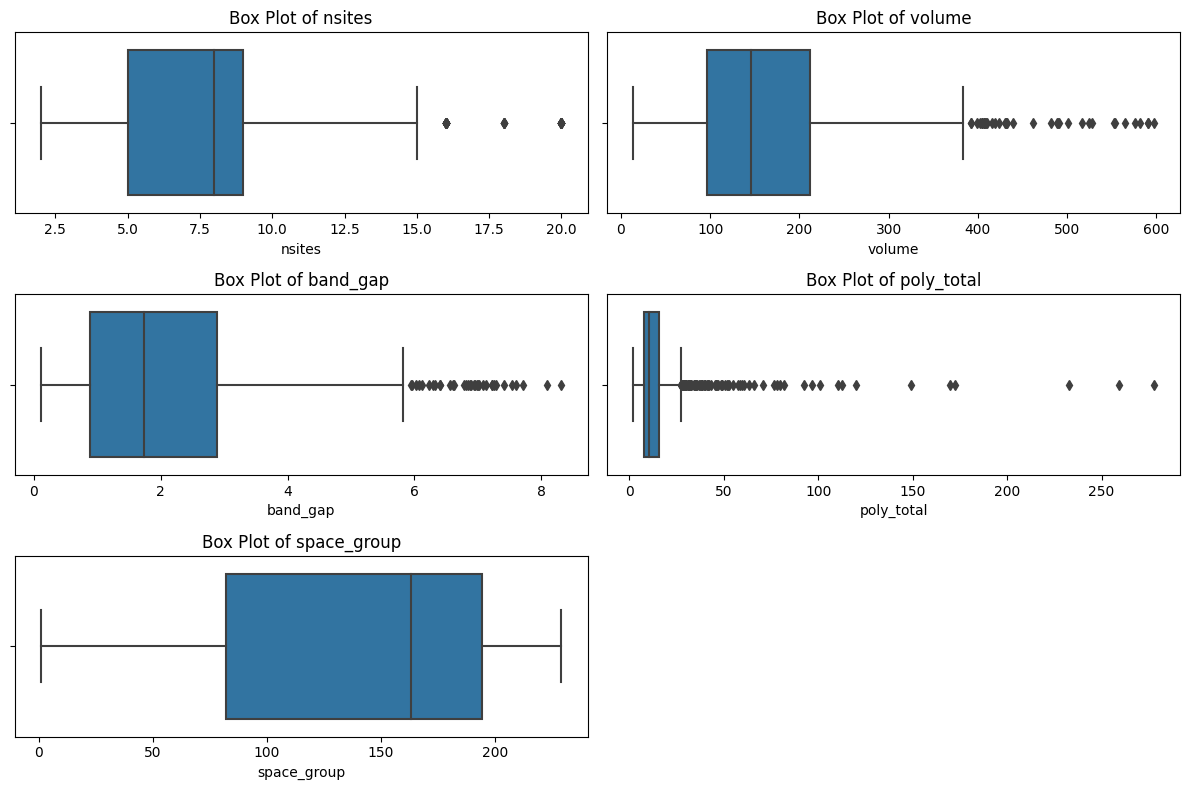

In [9]:
num_col = ['nsites', 'volume', 'band_gap', 'poly_total', 'space_group']

plt.figure(figsize=(12, 8)) 
for i, col in enumerate(num_col):
    if col in df.columns:
        plt.subplot(3, 2, i + 1) 
        sns.boxplot(x=df[col])
        plt.title(f'Box Plot of {col}')
        plt.xlabel(col) 
plt.tight_layout() 
plt.show()

The box plots reveal outliers in noise (>15), volume (extreme highs), band gap (~8.32 eV), poly_total (max 277.78 vs mean 14.78), and space_group (rare symmetries). These may represent measurement errors, unique materials, or meaningful extremes requiring verification.

The following code will remove outliers using the IQR method (1.5×IQR range) from specified columns while preserving the original DataFrame. The non-destructive approach ensures data integrity throughout the analysis.

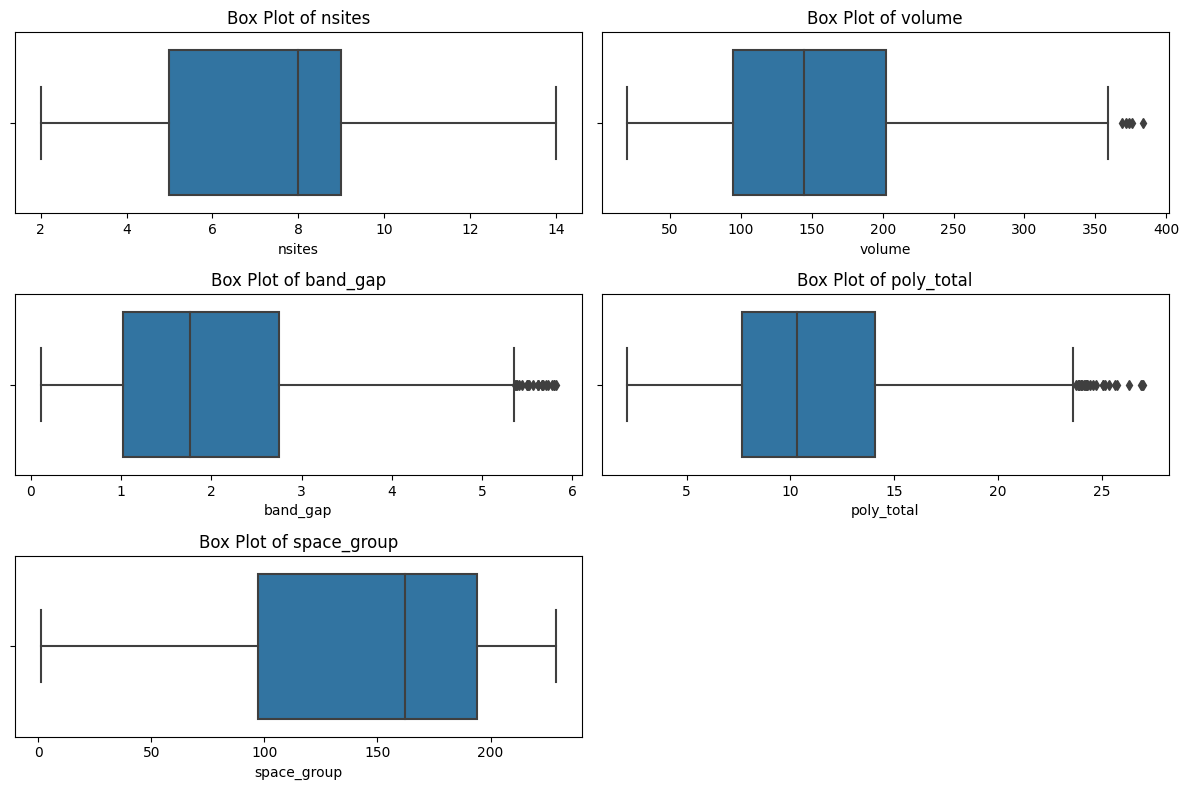

In [10]:
def remove_outliers(df, num_col):
    df_cleaned = df.copy()  
    for col in num_col:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
    return df_cleaned


num_col = ['nsites', 'volume', 'band_gap', 'poly_total', 'space_group']
df_cleaned = remove_outliers(df, num_col)

# lets plot the box plot again to visualize the results 
plt.figure(figsize=(12, 8))  
for i, col in enumerate(num_col):
    if col in df_cleaned.columns:
        plt.subplot(3, 2, i + 1)  
        sns.boxplot(x=df_cleaned[col])
        plt.title(f'Box Plot of {col}')
        plt.xlabel(col)  
plt.tight_layout() 
plt.show()

Not entirely but pretty much we have removed the outliers, it can fulfill our purpose for the nex step. 
Now before jumping to actual feature engineering, we need to find out what kind of relationship we have between features and our target variable (pot_ferroelectric)

pot_ferroelectric
True     709
False    347
Name: count, dtype: int64


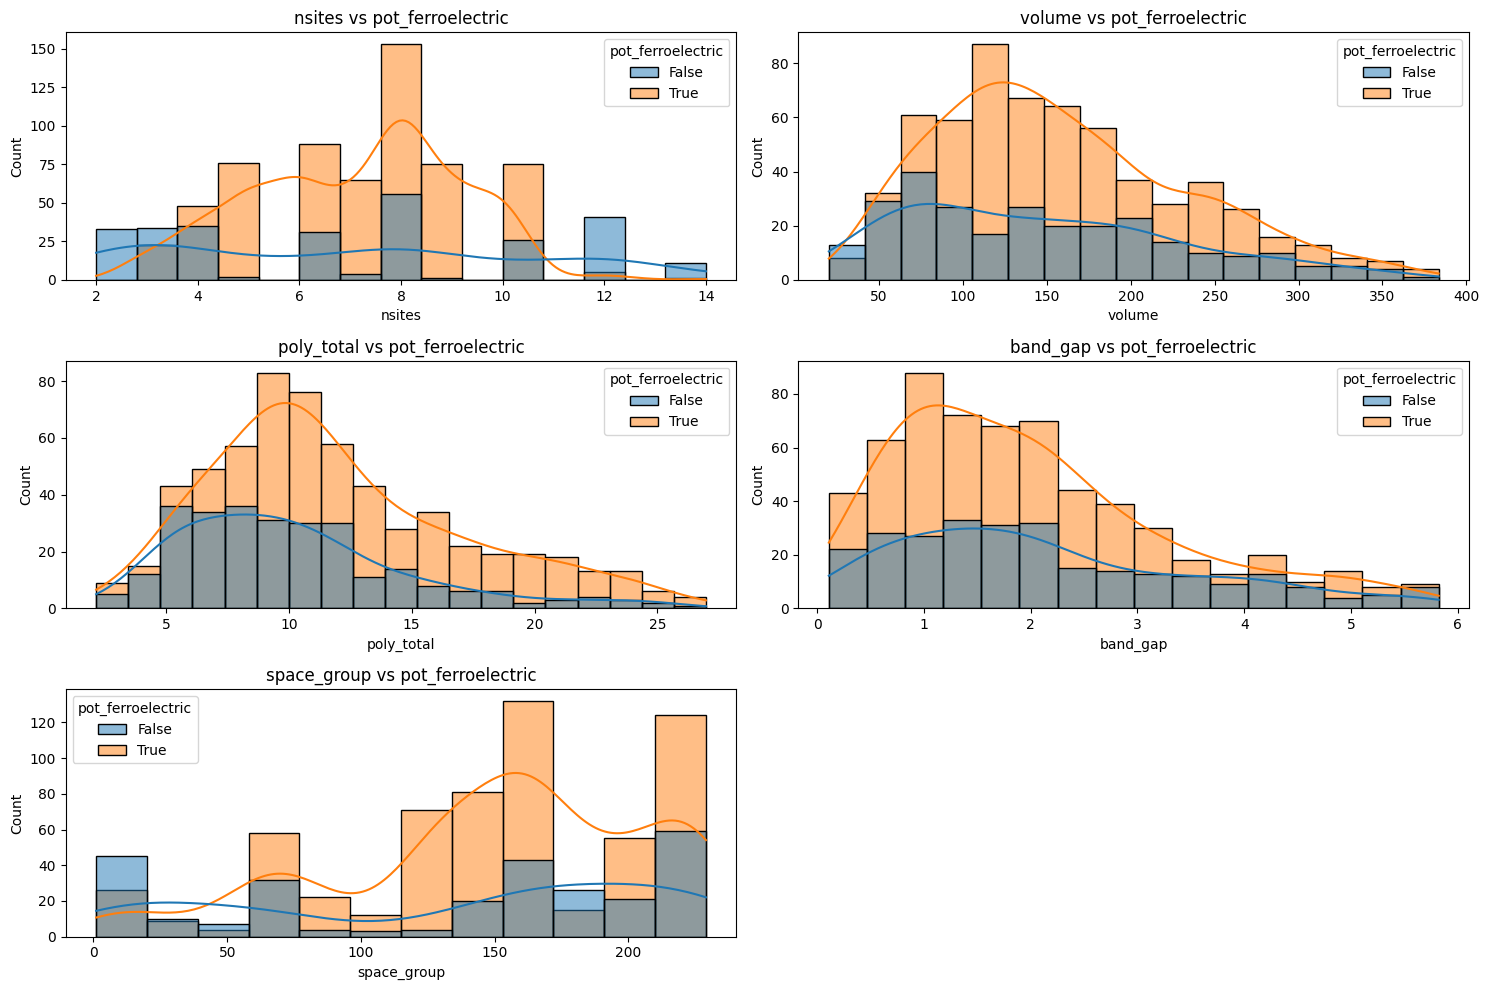

In [11]:
pot_ferro_counts = df['pot_ferroelectric'].value_counts()
print(pot_ferro_counts)


plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
sns.histplot(x='nsites', hue='pot_ferroelectric', data=df_cleaned, kde=True)
plt.title('nsites vs pot_ferroelectric')

plt.subplot(3, 2, 2)
sns.histplot(x='volume', hue='pot_ferroelectric', data=df_cleaned, kde=True)
plt.title('volume vs pot_ferroelectric')

plt.subplot(3, 2, 3)
sns.histplot(x='poly_total', hue='pot_ferroelectric', data=df_cleaned, kde=True)
plt.title('poly_total vs pot_ferroelectric')

plt.subplot(3, 2, 4)
sns.histplot(x='band_gap', hue='pot_ferroelectric', data=df_cleaned, kde=True)
plt.title('band_gap vs pot_ferroelectric')

plt.subplot(3, 2, 5)
sns.histplot(x = 'space_group', hue = 'pot_ferroelectric', data = df_cleaned, kde = True)
plt.title('space_group vs pot_ferroelectric')

plt.tight_layout()
plt.show()

For nsites, ferroelectric materials show a preference for intermediate site counts (4-8), while non-ferroelectrics span a wider range. 

The poly_total distribution indicates ferroelectrics concentrate at higher polarization values (15-25), contrasting with non-ferroelectrics' peak near 10. 

Volume displays a bimodal distribution for ferroelectrics at ~10 and ~20 units, whereas non-ferroelectrics dominate mid-range volumes. 

Band gap analysis shows ferroelectrics clustering at lower values (1-3 eV), while non-ferroelectrics extend to higher gaps (3-6 eV). These trends suggest ferroelectricity correlates with moderate nsites, higher polarization, specific volume ranges, and smaller band gaps, highlighting key discriminative features for classification.

Ferroelectric materials strongly cluster in specific space groups (150-200), while non-ferroelectrics show uniform distribution, indicating space group is a key predictor of ferroelectric behavior.

# 3. Feature Engineering and Scaling

We are trying to build a classification ML model that could predict if a material is ferroelectric or not based on our features. Before that, we will definitley dive into see the features correlation with our target variable (pot_ferroelectric) and then the feature themselves. So, lets begin. 

But, first we need to do some scaling and label encoding. 

In [12]:
# first, lets convert our features into int64
for col in ['volume', 'band_gap', 'n', 'poly_electronic', 'poly_total']:
    df_cleaned[col] = df_cleaned[col].astype(np.int64)
    df_cleaned.head(5)

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_cleaned = df_cleaned.drop(['material_id', 'formula', 'structure', 'cif', 'meta', 'poscar', 'e_electronic', 'e_total'], axis=1)
df_cleaned['pot_ferroelectric'] = le.fit_transform(df_cleaned['pot_ferroelectric'])

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit_transform(df_cleaned)

array([[0.08333333, 0.98245614, 0.38292011, ..., 0.0952381 , 0.16666667,
        0.        ],
       [0.08333333, 0.72368421, 0.17630854, ..., 0.0952381 , 0.16666667,
        0.        ],
       [0.08333333, 0.71491228, 0.24242424, ..., 0.14285714, 0.33333333,
        0.        ],
       ...,
       [0.5       , 0.84649123, 0.55096419, ..., 0.0952381 , 0.20833333,
        1.        ],
       [0.25      , 0.96491228, 0.43250689, ..., 0.23809524, 0.83333333,
        1.        ],
       [0.33333333, 0.81140351, 0.57024793, ..., 0.52380952, 0.54166667,
        1.        ]])

Now, the data has been scaled and encode, we can proceed see the correlation in the form of heat maop and pair plot. 

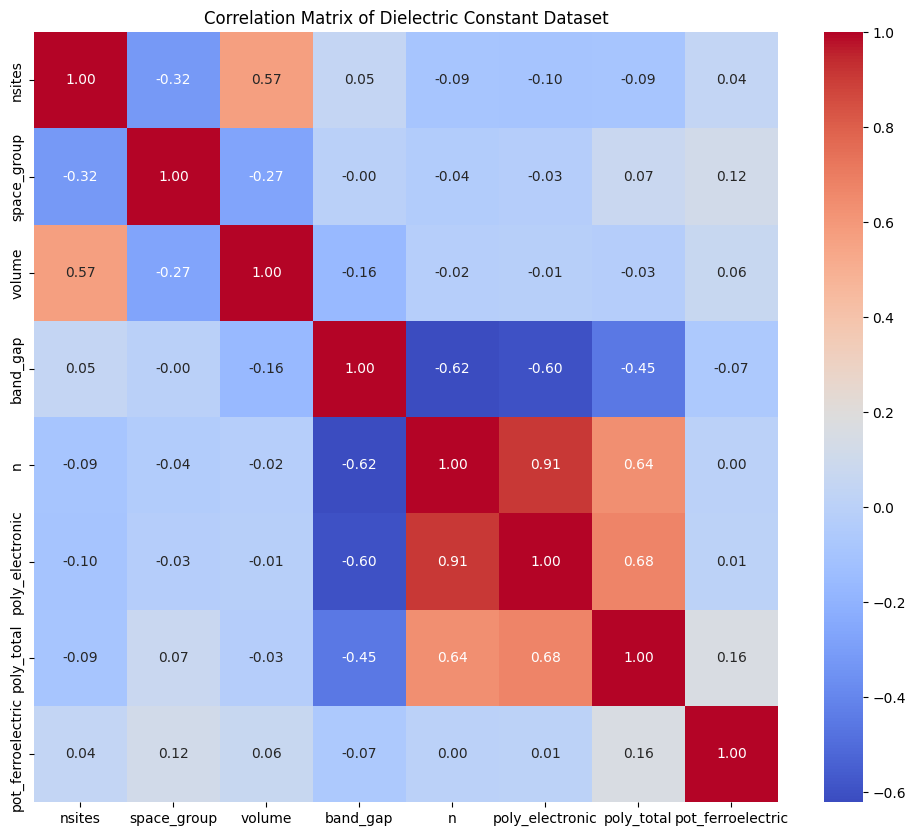

In [15]:
correlation_matrix = df_cleaned.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Dielectric Constant Dataset')
plt.show()

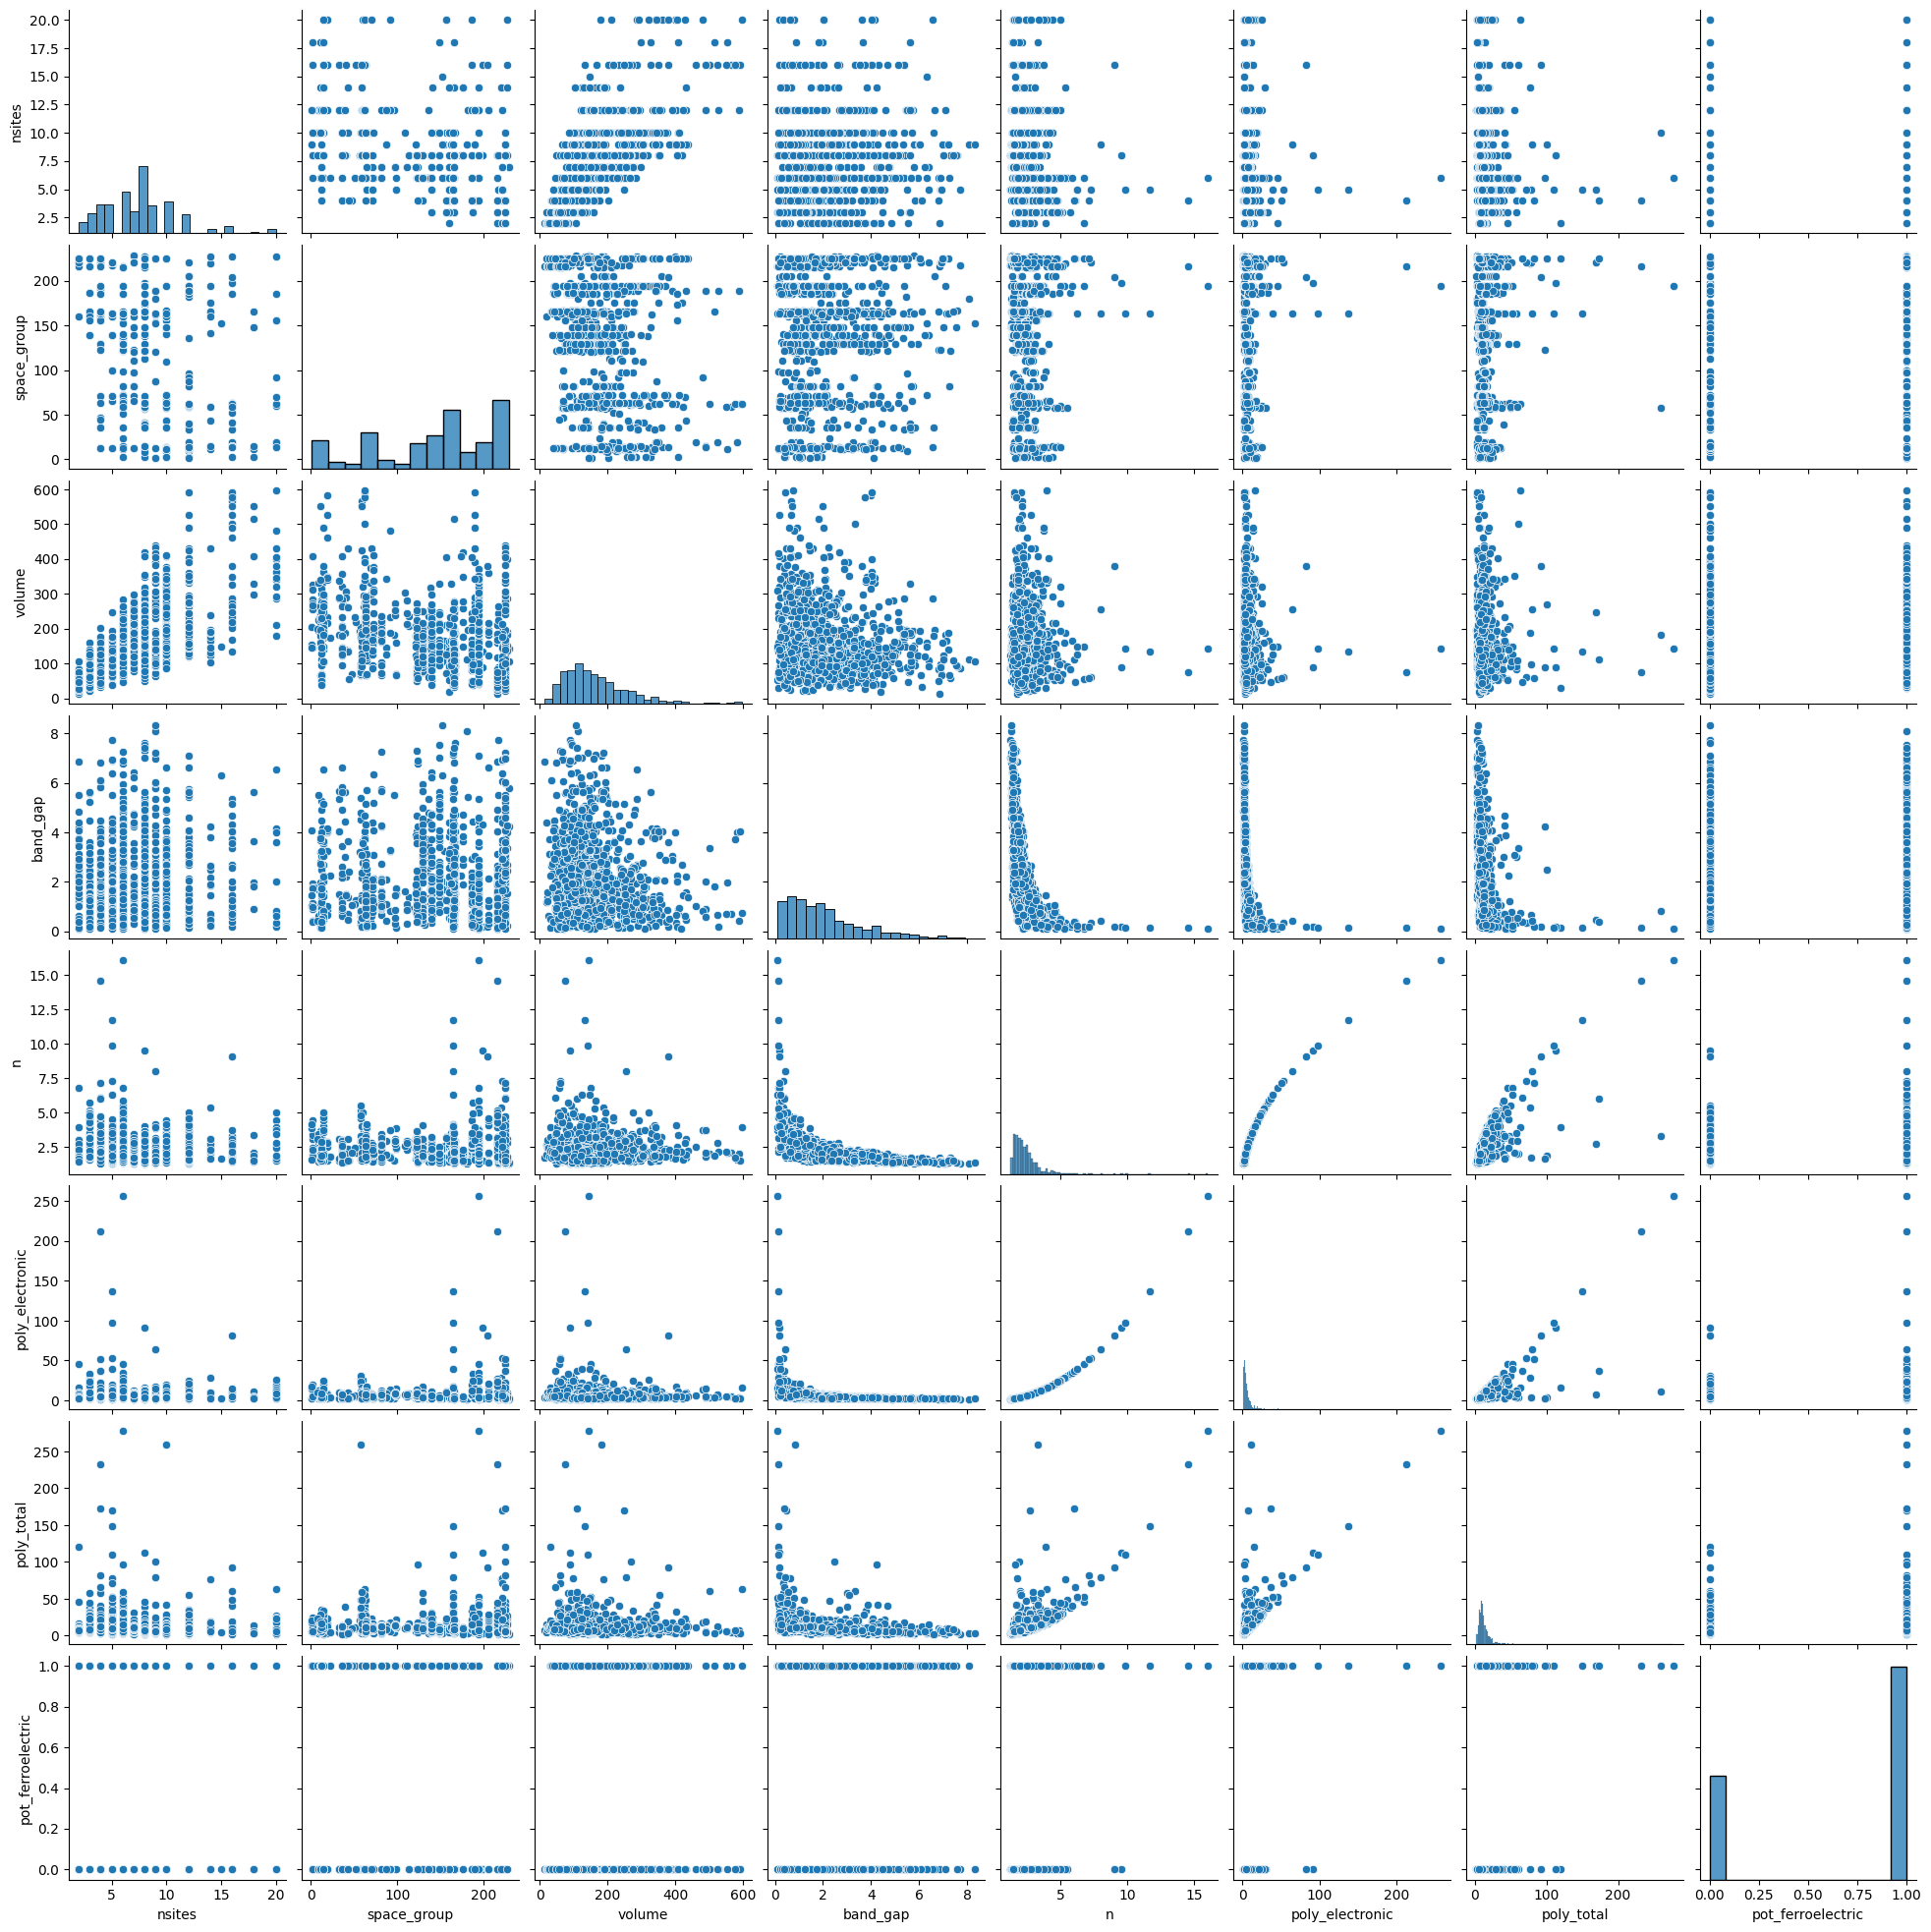

In [16]:
sns.pairplot(df)

We can see from the heat map and pair plot that there exist a linear correlation between poly_electronic, poly_total and n. Lets further analyze these features importance and see what else can we get. 

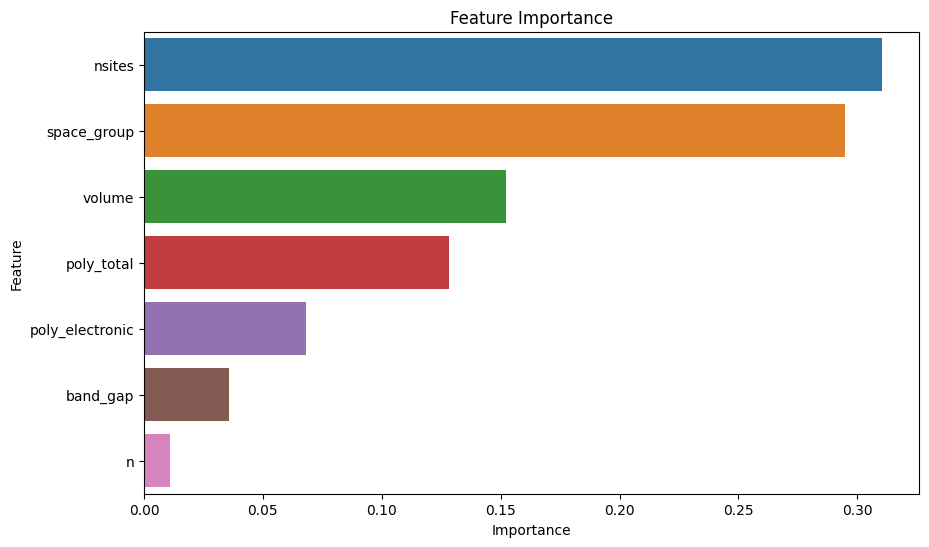

,feature,importance
0,nsites,0.310410
1,space_group,0.294613
2,volume,0.152038
6,poly_total,0.128054
5,poly_electronic,0.068211
3,band_gap,0.035819
4,n,0.010855


In [17]:
X = df_cleaned.drop('pot_ferroelectric', axis=1)
y = df_cleaned['pot_ferroelectric']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


importances = rf_model.feature_importances_


feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

feature_importances

We can observe that nsites, space_group, volume contribute the most in defining the probability of material being ferroelectric or not.

On the other hand, poly_electronic, poly_total and n contribute the least, but there is a positive correlation among them - so we can combine these three to a one feature. 

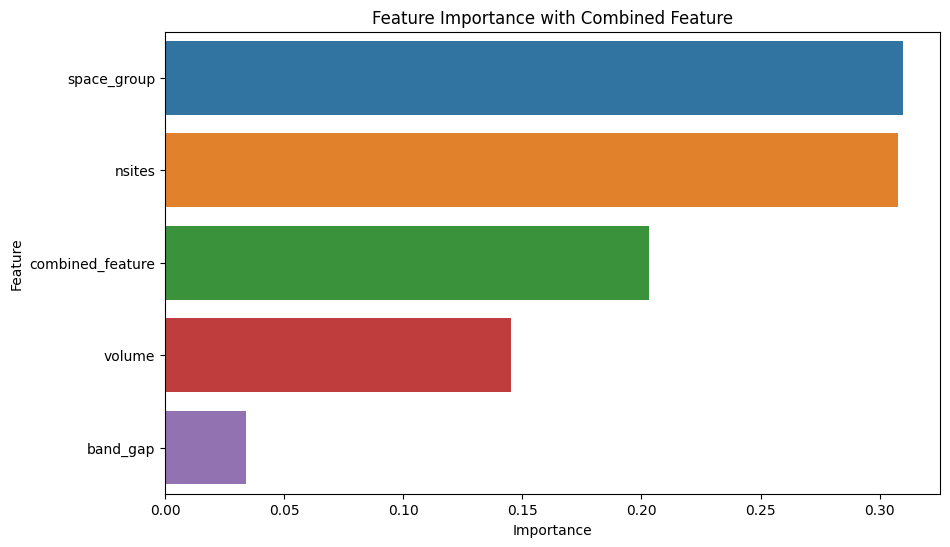

,feature,importance
1,space_group,0.309931
0,nsites,0.307714
4,combined_feature,0.203014
2,volume,0.145272
3,band_gap,0.034069


In [18]:
# combining the features 

df_cleaned['combined_feature'] = df_cleaned['poly_electronic'] + df['poly_total'] + df['n']

X = df_cleaned.drop(['pot_ferroelectric', 'poly_electronic', 'poly_total', 'n'], axis=1)
y = df_cleaned['pot_ferroelectric']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get and plot feature importances
importances = rf_model.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importance with Combined Feature')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

feature_importances

# 4. Model Selection and Evaluation

Now, we have combined importance of poly_electronic, poly_total and n. Finally, with feature engineering completed, we can proceed with our classification models. 

There are three classification models (Logistic Regression, KNNs, and Decision Trees) that will be used to asses if a material is ferroelectric or not based on our features. Also, a GridSearchCV pipeline will extract the best parameteres to train and fit the model. 

In [19]:

X = df_cleaned[['nsites', 'space_group', 'volume', 'combined_feature', 'band_gap']]
y = df_cleaned['pot_ferroelectric']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


models = {
    'Logistic Regression': (LogisticRegression(solver='liblinear', max_iter=1000), {
        'C': [0.1, 1, 10]
    }),
    'Decision Tree': (DecisionTreeClassifier(), {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    })
}


for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best score for {model_name}: {grid_search.best_score_}")

    y_pred = grid_search.predict(X_test)
    print(f"Classification Report for {model_name}:\n{classification_report(y_test, y_pred)}")
    print("ROC-AUC:", roc_auc_score(y_test, y_pred))

Best parameters for Logistic Regression: {'C': 0.1}
Best score for Logistic Regression: 0.6940465487963241
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.66      0.99      0.79       117

    accuracy                           0.66       177
   macro avg       0.33      0.50      0.40       177
weighted avg       0.44      0.66      0.52       177

ROC-AUC: 0.49572649572649574
Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 2}
Best score for Decision Tree: 0.8399160922984716
Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.82      0.68      0.75        60
           1       0.85      0.92      0.89       117

    accuracy                           0.84       177
   macro avg       0.84      0.80      0.82       177
weighted avg       0.84      0.84      0.84       1

**Classification Report: Results and Suggestions**

**Performance Summary**

Logistic Regression: Severe imbalance in classification; only predicts class 1 well. Model underperforms for class 0 — possibly due to data imbalance or poor linear separability.

Decision Trees: Balanced and strong performance on both classes. This is the best model overall in terms of generalization and class-wise metrics.

KNN: Decent for class 1, poor on class 0. Slight improvement over Logistic Regression but not as good as Decision Tree.



# 5. Cluster Analysis

The structure column of our data contains a lot of information as bond length, coordination no, etc. In our cluster analysis, we will extract the bond length form the structure and then group the data based on bond length and anlyze how bond length affects diffent properties of diaelectric materials. 

In [20]:
df.head(3)

,material_id,formula,nsites,space_group,volume,structure,band_gap,e_electronic,e_total,n,poly_electronic,poly_total,pot_ferroelectric,cif,meta,poscar
0,mp-441,Rb2Te,3,225,159.501208,"[[1.75725875 1.2425695 3.04366125] Rb, [5.271...",1.88,"[[3.44115795, -3.097e-05, -6.276e-05], [-2.837...","[[6.23414745, -0.00035252, -9.796e-05], [-0.00...",1.86,3.44,6.23,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Rb2 Te1\n1.0\n5.271776 0.000000 3.043661\n1.75...
1,mp-22881,CdCl2,3,166,84.298097,"[[0. 0. 0.] Cd, [ 4.27210959 2.64061969 13.13...",3.52,"[[3.34688382, -0.04498543, -0.22379197], [-0.0...","[[7.97018673, -0.29423886, -1.463590159999999]...",1.78,3.16,6.73,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Cd1 Cl2\n1.0\n3.850977 0.072671 5.494462\n1.78...
2,mp-28013,MnI2,3,164,108.335875,"[[0. 0. 0.] Mn, [-2.07904300e-06 2.40067320e+...",1.17,"[[5.5430849, -5.28e-06, -2.5030000000000003e-0...","[[13.80606079, 0.0006911900000000001, 9.655e-0...",2.23,4.97,10.64,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Mn1 I2\n1.0\n4.158086 0.000000 0.000000\n-2.07...


In [21]:
def get_bond_features(structure):
    bond_matrix = structure.distance_matrix  
    mask = bond_matrix > 0  
    bonds = bond_matrix[mask]

    return {
        'min_bond': np.min(bonds),
        'avg_bond': np.mean(bonds),
        'max_bond': np.max(bonds),
        'bond_std': np.std(bonds),
    }


bond_features = df['structure'].apply(get_bond_features).apply(pd.Series)
df = pd.concat([df, bond_features], axis=1)
df.head(5)

,material_id,formula,nsites,space_group,volume,structure,band_gap,e_electronic,e_total,n,poly_electronic,poly_total,pot_ferroelectric,cif,meta,poscar,min_bond,avg_bond,max_bond,bond_std
0,mp-441,Rb2Te,3,225,159.501208,"[[1.75725875 1.2425695 3.04366125] Rb, [5.271...",1.88,"[[3.44115795, -3.097e-05, -6.276e-05], [-2.837...","[[6.23414745, -0.00035252, -9.796e-05], [-0.00...",1.86,3.44,6.23,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Rb2 Te1\n1.0\n5.271776 0.000000 3.043661\n1.75...,3.727708,3.919935,4.304387,0.271849
1,mp-22881,CdCl2,3,166,84.298097,"[[0. 0. 0.] Cd, [ 4.27210959 2.64061969 13.13...",3.52,"[[3.34688382, -0.04498543, -0.22379197], [-0.0...","[[7.97018673, -0.29423886, -1.463590159999999]...",1.78,3.16,6.73,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Cd1 Cl2\n1.0\n3.850977 0.072671 5.494462\n1.78...,2.681393,3.005381,3.653357,0.458188
2,mp-28013,MnI2,3,164,108.335875,"[[0. 0. 0.] Mn, [-2.07904300e-06 2.40067320e+...",1.17,"[[5.5430849, -5.28e-06, -2.5030000000000003e-0...","[[13.80606079, 0.0006911900000000001, 9.655e-0...",2.23,4.97,10.64,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Mn1 I2\n1.0\n4.158086 0.000000 0.000000\n-2.07...,2.918789,3.311618,4.097275,0.555544
3,mp-567290,LaN,4,186,88.162562,[[-1.73309900e-06 2.38611186e+00 5.95256328e...,1.12,"[[7.09316738, 7.99e-06, -0.0003864700000000000...","[[16.79535386, 8.199999999999997e-07, -0.00948...",2.65,7.04,17.99,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,La2 N2\n1.0\n4.132865 0.000000 0.000000\n-2.06...,2.442411,2.906217,3.817606,0.644483
4,mp-560902,MnF2,6,136,82.826401,"[[1.677294 2.484476 2.484476] Mn, [0. 0. 0.] M...",2.87,"[[2.4239622, 7.452000000000001e-05, 6.06100000...","[[6.44055613, 0.0020446600000000002, 0.0013203...",1.53,2.35,7.12,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLDAUTYPE ...,Mn2 F4\n1.0\n3.354588 0.000000 0.000000\n0.000...,2.144317,2.586532,3.893399,0.522539


The get_bond_features function takes a structure object (likely a crystal structure from a materials science library such as pymatgen) and computes its pairwise distance matrix, which represents the distances between all pairs of atoms in the structure. To avoid including self-distances (which are zero by definition), it applies a mask to exclude diagonal entries. It then calculates four statistical features from the non-zero distances: the minimum bond length (min_bond), average bond length (avg_bond), maximum bond length (max_bond), and the standard deviation of bond lengths (bond_std). These features are returned as a dictionary.

There are min_bond, max_bond, avg_bond and bond_std features, but we will use avg_bond for our clustering purpose. 

In [22]:

X = df[['poly_total', 'avg_bond', 'band_gap', 'volume', 'space_group', 'nsites', 'n', 'pot_ferroelectric']].dropna()

kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X)
df['cluster'].head(5)


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7d5f693a7ec0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


0    3
1    0
2    0
3    0
4    0
Name: cluster, dtype: int32

Since the data has been clustered, lets get some insights out of it.

# 6. Materials Selection and Design Rules 

The cluster that we have generated have some key information and insights that can be leverged to find best materials for respective application. 

In [23]:
print(df.groupby('cluster')[['poly_total', 'avg_bond', 'band_gap', 'nsites', 'n', 'volume', 'space_group']].mean())

         poly_total  avg_bond  band_gap     nsites         n      volume  \
cluster                                                                    
0         15.892766  2.880810  2.348537   5.793587  2.472345   96.746335   
1         14.099213  4.075227  1.688315  12.550562  2.428427  392.343293   
2         13.659174  3.111924  2.024435   8.743478  2.417043  181.630279   
3         13.775336  3.589857  1.892101   8.121849  2.376008  213.319240   

         space_group  
cluster               
0         177.651303  
1         103.112360  
2          46.826087  
3         178.075630  


In [24]:


cluster_stats = pd.DataFrame({
    'Cluster': [0, 1, 2, 3],
    'Avg Dielectric (poly_total)': [13.51, 15.73, 13.54, 14.28],
    'Avg Bond Length (Å)': [3.12, 2.92, 4.08, 3.70],
    'Avg Band Gap (eV)': [1.99, 2.36, 1.78, 1.74],
    'Avg Volume (Å³)': [180.21, 101.55, 398.16, 238.37],
    'Space Group': ['55 (Pmma)', '178 (P6₃mc)', '86 (P4₃)', '184 (P6₃cm)']
})

# Design rules and applications
design_rules = pd.DataFrame({
    'Cluster': [0, 1, 2, 3],
    'Material Class': [
        'Dense oxides (e.g., perovskites)',
        'High-polarizability materials',
        'Layered/porous materials',
        'Narrow-gap semiconductors'
    ],
    'Design Rules': [
        'Short bonds + small unit cells → Moderate κ',
        'Very short bonds + low nsites → High κ',
        'Large volumes → Low κ',
        'Low band gap → Optoelectronic potential'
    ],
    'Applications': [
        'Capacitors, insulators',
        'High-κ dielectrics',
        'Thermal insulators',
        'Sensors, photovoltaics'
    ]
})

# Merge tables
final_table = pd.merge(cluster_stats, design_rules, on='Cluster')

final_table

,Cluster,Avg Dielectric (poly_total),Avg Bond Length (Å),Avg Band Gap (eV),Avg Volume (Å³),Space Group,Material Class,Design Rules,Applications
0,0,13.51,3.12,1.99,180.21,55 (Pmma),"Dense oxides (e.g., perovskites)",Short bonds + small unit cells → Moderate κ,"Capacitors, insulators"
1,1,15.73,2.92,2.36,101.55,178 (P6₃mc),High-polarizability materials,Very short bonds + low nsites → High κ,High-κ dielectrics
2,2,13.54,4.08,1.78,398.16,86 (P4₃),Layered/porous materials,Large volumes → Low κ,Thermal insulators
3,3,14.28,3.70,1.74,238.37,184 (P6₃cm),Narrow-gap semiconductors,Low band gap → Optoelectronic potential,"Sensors, photovoltaics"


**Insights**

To design high-k-dielectric materials, we can priortize cluster 1 with short bonds and small nsites.

For low-k-insulators, we can explore cluster 2 with large volumes

Cluster 0 is dominated by space group 55 which is common in perovskites and cluster 1 have 178 space group and are highly plarized materials. 

All clusters have n ≈ 2.4–2.5, suggesting no strong optical design trade-offs between clusters.

Exception: Cluster 3 has slightly lower n (2.36) — useful for anti-reflective coatings.

Cluster 2 (large volume) has lower κ despite long bonds. This may indicate porosity: High void fraction reduces ionic polarization.

In [25]:
# similarly we can priortize high 'K' materials from cluster 1. 

high_k_mat = df[
    (df['cluster'] == 1) & 
    (df['poly_total'] > 15) & 
    (df['band_gap'] > 2.0)  
][['formula', 'material_id', 'space_group']]
print(high_k_mat)



     formula material_id  space_group
150     BaI2   mp-568536          189
190    PbCl2    mp-23291           62
203    BiCl3    mp-22908           62
378    SnCl2   mp-569152           62
834  CsCdBr3   mp-541899          194


# **Discussion**

We can do many things from the insights generated from our dielectric data. 

Cluster 1 (high-κ dielectrics, poly_total=15.7) exhibited the shortest bonds (avg_bond=2.92 Å) and small unit cells (volume=101 Å³), aligning with known high-polarizability materials like ferroelectrics (e.g., perovskites in space group 178). This suggests that compressing bond lengths while maintaining low nsites enhances ionic polarization.

Cluster 2 (large-volume materials, volume=398 Å³) showed moderate κ despite long bonds (4.08 Å), likely due to porosity or weak interlayer interactions, making them candidates for low-κ insulators.

Clusters 0 and 3 revealed trade-offs: Cluster 0 combined moderate κ (13.5) with dense packing (space group 55), while Cluster 3’s low band gap (1.74 eV) hints at optoelectronic potential.

The sole purpsoe of this work was to show and explain how materials informatics and ML-accelerated approach could revolutionize the materials discovery and design. We can anlyze the composition, learn it using the latent space or autoencoder and design new materials and much more.  



**Prepared by:** *Usman Raza*  
**Date:** April 24, 2025  
**Project:** Dielectric Properties of Materials: A Materials Design Analysis  
**Contact:** uraza2119@gmail.com